# xgboost

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime
import re

In [2]:
###データ読込(結合したデータ)
train = pd.read_csv("~/repo/study/JLeague/data/train_new4.csv")
test = pd.read_csv("~/repo/study/JLeague/data/test_new4.csv")
player = pd.read_csv("~/repo/study/JLeague/data/player.csv")
test_id = pd.read_csv("~/repo/study/JLeague/motodata/test.csv")["id"]
test_id_all = test["id"]

## Feature Enginiering

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 50 columns):
id             1952 non-null int64
y              1952 non-null int64
year           1952 non-null int64
stage          1952 non-null object
match          1952 non-null object
gameday        1952 non-null object
time           1952 non-null object
home           1952 non-null object
away           1952 non-null object
stadium        1952 non-null object
tv             1952 non-null object
home_score     1952 non-null int64
away_score     1952 non-null int64
weather        1952 non-null object
temperature    1952 non-null float64
humidity       1952 non-null object
referee        1952 non-null object
home_team      1952 non-null object
home_01        1952 non-null object
home_02        1952 non-null object
home_03        1952 non-null object
home_04        1952 non-null object
home_05        1952 non-null object
home_06        1952 non-null object
home_07        1952 non-null obje

In [4]:
def j2num(j):
    return 1 if j == 'Ｊ１' else 0
train["stage"] = train["stage"].map(j2num)
test["stage"] = test["stage"].map(j2num)

In [5]:
for i, weather in enumerate(train["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        train.ix[i, "rain"] = 1
    else:
        train.ix[i, "rain"] = 0
for i, weather in enumerate(test["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        test.ix[i, "rain"] = 1
    else:
        test.ix[i, "rain"] = 0

/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [8]:
for i, m in enumerate(train["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    train.ix[i, "section"] = int(match[0])
    train.ix[i, "no"] = int(match[1])
for i, m in enumerate(test["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    test.ix[i, "section"] = int(match[0])
    test.ix[i, "no"] = int(match[1])

In [55]:
if (train.stage[0] == 1):
    train["sec_diff"] = np.abs(train["section"] - 17)**2
    test["sec_diff"] = np.abs(test["section"] - 17)**2
else:
    train["sec_diff"] = np.abs(train["section"] - 21)**2
    test["sec_diff"] = np.abs(test["section"] - 21)**2

In [9]:
for i, tv in enumerate(train["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    train.ix[i, "media"] = int(len(tvlist))
for i, tv in enumerate(test["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    test.ix[i, "media"] = int(len(tvlist))

In [10]:
for i, day in enumerate(train["gameday"]):
    day = str(day)
    train.ix[i, "month"] = int(day[:2])
    train.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        train.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        train.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        train.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        train.ix[i, "weekday"] = 2
    else:
        train.ix[i, "weekday"] = 3
for i, day in enumerate(test["gameday"]):
    day = str(day)
    test.ix[i, "month"] = int(day[:2])
    test.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        test.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        test.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        test.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        test.ix[i, "weekday"] = 2
    else:
        test.ix[i, "weekday"] = 3

In [11]:
from dateutil.parser import parse
for i, t in enumerate(train["time"]):
    train.ix[i, "hour"] = int(str(t)[:2])
for i, t in enumerate(test["time"]):
    test.ix[i, "hour"] = int(str(t)[:2])

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["home"])
train["home"] = le.transform(train["home"])
train["away"] = le.transform(train["away"])
test["home"] = le.transform(test["home"])
test["away"] = le.transform(test["away"])

In [13]:
for i, t in enumerate(train["humidity"]):
    train.ix[i, "humid"] = int(str(t)[:2])
for i, t in enumerate(test["humidity"]):
    test.ix[i, "humid"] = int(str(t)[:2])

In [14]:
def discomfort_index(T, H):
    return 0.81*T+0.01*H*(0.99*T - 14.3) + 46.3
train["discomfort"] = discomfort_index(train["temperature"], train["humid"])
test["discomfort"] = discomfort_index(test["temperature"], test["humid"])

In [15]:
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary

In [16]:
train["home_all"] = train[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
train["away_all"] = train[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 
test["home_all"] = test[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
test["away_all"] = test[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 

In [17]:
train.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'specific', 'prefecture',
       'latitude', 'longitude', 'population', 'area', 'dencity', 'rain',
       'section', 'day', 'media', 'no', 'month', 'weekday', 'hour', 'humid',
       'discomfort', 'home_all', 'away_all'],
      dtype='object')

In [56]:
train1 = train[["y", "year", "capa", "home_score", "away_score", "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all", "stage", "specific", "latitude", "longitude", "population", "area", "dencity", "rain","sec_diff"]]
test1 = test[["capa", "home_score", "away_score",  "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all", "stage", "specific", "latitude", "longitude", "population", "area", "dencity", "rain", "sec_diff"]]

In [57]:
y1 = train1["y"]
train1 = train1.drop(["y", "year"], axis=1)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train1, y1, test_size=0.2, random_state=17)

## build model

In [59]:
import xgboost
from xgboost import XGBRegressor
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

In [60]:
model = XGBRegressor(eval_metrics='rmse', random_state=17)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metrics='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=17, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [61]:
pred = model.predict(X_test)

In [62]:
np.sqrt(mean_squared_error(y_test, pred))

2890.8714597859171

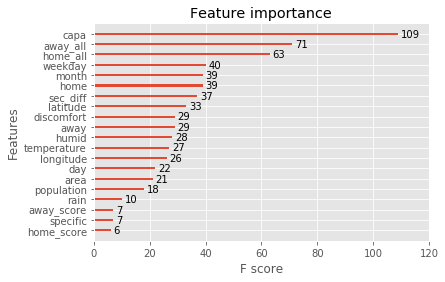

In [63]:
plt.style.use('ggplot')
xgboost.plot_importance(model, max_num_features=20)

## submit

In [64]:
pred = model.predict(test1)

In [65]:
for i, p in enumerate(pred):
    if p > test1.ix[i, "capa"]:
        pred[i] = test1.ix[i, "capa"]
    else:
        pred[i] = p

/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [66]:
for i, p in enumerate(pred):
    if p < min(y1):
        print(p, min(y1))
        pred[i] = min(y1)
    else:
        pred[i] = p

In [67]:
pred = pd.DataFrame(pred, columns={"pred"})
pred["id"] = test_id_all

In [68]:
test_id = pd.DataFrame(test_id)
test_id["id"] = test_id

In [69]:
pred = pd.merge(pred, test_id, how="right", on=["id"])

In [70]:
pred = pred.loc[:, ["id", "pred"]]

In [71]:
pred.to_csv("~/repo/study/JLeague/submit/submit_1126_5_xgboost.csv", index=False, header=False)